In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# 1. Load and preprocess data
dataset_path = 'D:/dataset_selected'
img_size = 64
X, y = [], []

# Function to calculate image intensity (for paralysis folder)
def calculate_image_intensity(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

In [4]:
# Iterate through the dataset
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    for file in os.listdir(folder_path):
        try:
            path = os.path.join(folder_path, file)
            img = cv2.imread(path)
            img = cv2.resize(img, (img_size, img_size))
            
            if folder.lower() == 'normal':
                label = 0  # Normal
            elif folder.lower() == 'paralysis':
                intensity = calculate_image_intensity(img)
                if intensity <= 100:
                    label = 1  # Mild
                elif intensity <= 150:
                    label = 2  # Moderate
                else:
                    label = 3  # Severe
            else:
                continue  # Skip unknown folders

            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Error in {file}: {e}")

In [5]:
X = np.array(X) / 255.0  # Normalize images
y = to_categorical(np.array(y), num_classes=4)  # One-hot encode labels


In [6]:
# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# 3. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


In [8]:
# 4. CNN Model (Improved)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes (Normal, Mild, Moderate, Severe)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

C:\Users\Bhuvana\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# 5. Training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])


Epoch 1/50


C:\Users\Bhuvana\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.5591 - loss: 1.0331 - val_accuracy: 0.8416 - val_loss: 0.4510
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.7837 - loss: 0.5453 - val_accuracy: 0.8598 - val_loss: 0.3940
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.8193 - loss: 0.4697 - val_accuracy: 0.8749 - val_loss: 0.3299
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.8368 - loss: 0.4290 - val_accuracy: 0.8837 - val_loss: 0.2856
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.8521 - loss: 0.3757 - val_accuracy: 0.9026 - val_loss: 0.2487
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.8684 - loss: 0.3599 - val_accuracy: 0.9170 - val_loss: 0.2093
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.8736 - loss: 0.3482 - val_accuracy: 0.9107 - val_loss: 0.2110
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.8747 - loss: 0.3179 - val_accurac

In [10]:
# 6. Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


In [11]:
# Evaluation metrics
acc = np.mean(y_pred_classes == y_true)
prec = precision_score(y_true, y_pred_classes, average='weighted')
rec = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
mae = mean_absolute_error(y_true, y_pred_classes)
rmse = mean_squared_error(y_true, y_pred_classes, squared=False)
cm = confusion_matrix(y_true, y_pred_classes)


C:\Users\Bhuvana\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[806   1   3   2]
 [  6 395  16   0]
 [ 19  13 283   0]
 [  9   0  14  24]]


In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Mild', 'Moderate', 'Severe']))


              precision    recall  f1-score   support

      Normal       0.96      0.99      0.98       812
        Mild       0.97      0.95      0.96       417
    Moderate       0.90      0.90      0.90       315
      Severe       0.92      0.51      0.66        47

    accuracy                           0.95      1591
   macro avg       0.94      0.84      0.87      1591
weighted avg       0.95      0.95      0.95      1591



In [14]:
print("\nEvaluation Metrics:")
print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("F1 Score:", round(f1, 4))
print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))



Evaluation Metrics:
Accuracy: 0.9478
Precision: 0.9474
Recall: 0.9478
F1 Score: 0.9457
MAE: 0.0798
RMSE: 0.386


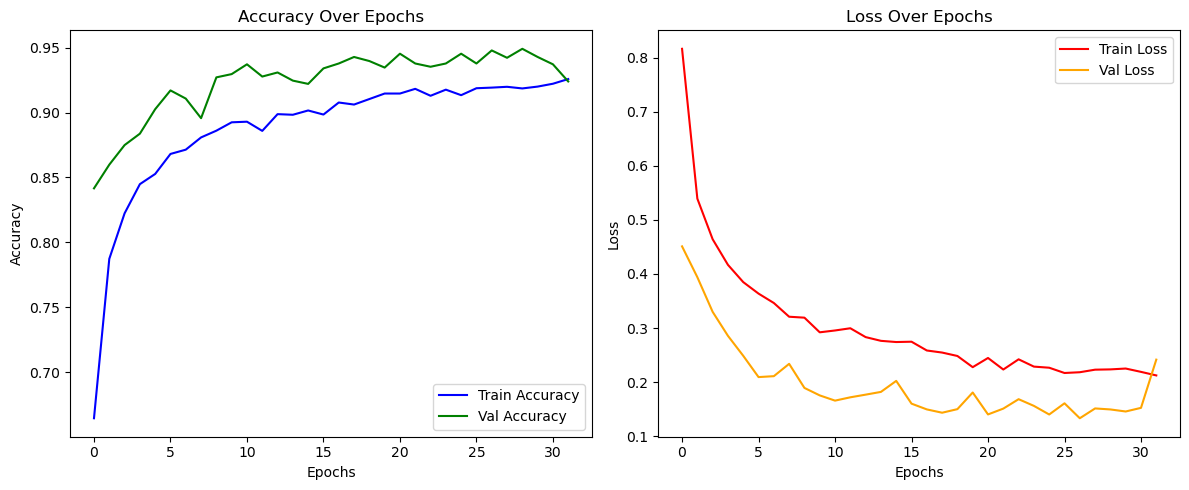

In [15]:
# 7. Plot training vs validation accuracy & loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

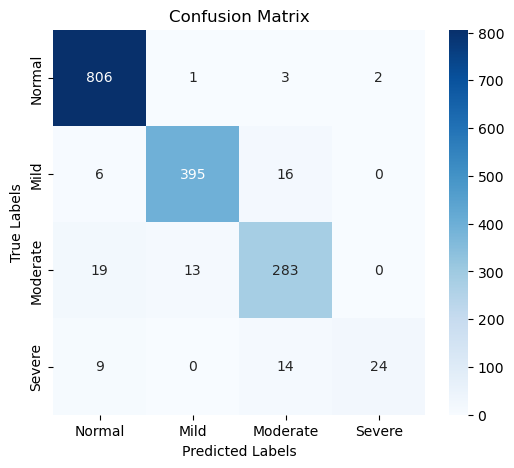

In [16]:
import seaborn as sns

# 1. Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Mild', 'Moderate', 'Severe'], yticklabels=['Normal', 'Mild', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


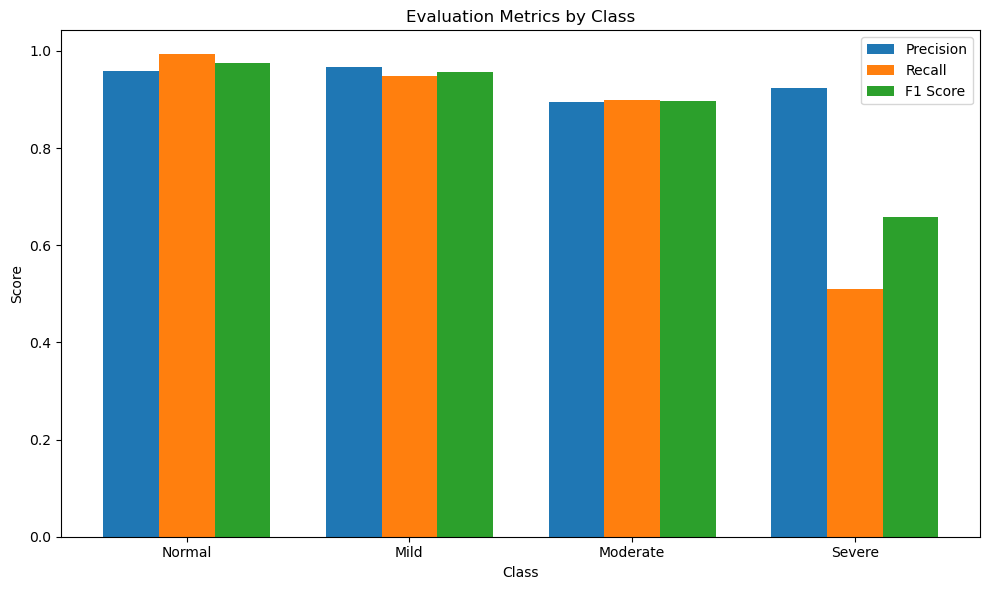

In [17]:
# Assuming cm has shape (4, 4) for confusion matrix (class-wise)
classes = ['Normal', 'Mild', 'Moderate', 'Severe']

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Custom color palette
colors_precision = ['#4CAF50', '#FF9800', '#2196F3', '#9C27B0']  # Green, Orange, Blue, Purple
colors_recall = ['#FFC107', '#673AB7', '#00BCD4', '#8BC34A']  # Amber, Deep Purple, Cyan, Light Green
colors_f1 = ['#FF5722', '#607D8B', '#CDDC39', '#E91E63']  # Deep Orange, Blue Grey, Lime, Pink

# Plotting
x = np.arange(len(classes))  # The class labels (Normal, Mild, etc.)
width = 0.25  # Bar
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for precision, recall, and F1 score
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1 Score')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()



In [18]:
# 8. Save the model
model.save("paralysis_detection_cnn_model.keras")

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and preprocess data
dataset_path = 'D:/dataset_selected'
img_size = 64
X, y = [], []

# Function to calculate image intensity (for paralysis folder)
def calculate_image_intensity(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

In [20]:
# Iterate through the dataset
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    for file in os.listdir(folder_path):
        try:
            path = os.path.join(folder_path, file)
            img = cv2.imread(path)
            img = cv2.resize(img, (img_size, img_size))
            
            if folder.lower() == 'normal':
                label = 0  # Normal
            elif folder.lower() == 'paralysis':
                intensity = calculate_image_intensity(img)
                if intensity <= 100:
                    label = 1  # Mild
                elif intensity <= 150:
                    label = 2  # Moderate
                else:
                    label = 3  # Severe
            else:
                continue  # Skip unknown folders

            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Error in {file}: {e}")


In [21]:
X = np.array(X) / 255.0  # Normalize images
y = to_categorical(np.array(y), num_classes=4)  # One-hot encode labels

# Reshape data for LSTM input (adding an additional dimension for time-step or sequence length)
X = X.reshape(X.shape[0], 1, img_size, img_size, 3)  

In [22]:
# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# 3. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

# Reshape data for LSTM input (removing the extra time-step dimension)
X_train_reshaped = X_train.reshape(X_train.shape[0], img_size, img_size, 3)  # 4D array (samples, height, width, channels)
X_test_reshaped = X_test.reshape(X_test.shape[0], img_size, img_size, 3)  # 4D array

datagen.fit(X_train_reshaped)  # Fit the datagen to the reshaped data


In [24]:
# Reshape input data for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape(X_train.shape[0], img_size, img_size * 3)  # (samples, timesteps, features)
X_test_lstm = X_test.reshape(X_test.shape[0], img_size, img_size * 3)  # (samples, timesteps, features)

# 4. LSTM Model
model = Sequential([
    LSTM(128, input_shape=(img_size, img_size * 3), return_sequences=False),  # LSTM layer
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes (Normal, Mild, Moderate, Severe)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 5. Training
history = model.fit(X_train_lstm, y_train, epochs=50, validation_data=(X_test_lstm, y_test), batch_size=32, callbacks=[early_stop])


C:\Users\Bhuvana\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.6072 - loss: 0.9413 - val_accuracy: 0.7568 - val_loss: 0.6176
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.7179 - loss: 0.6848 - val_accuracy: 0.7995 - val_loss: 0.5087
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.7705 - loss: 0.5857 - val_accuracy: 0.8297 - val_loss: 0.4358
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.8217 - loss: 0.4832 - val_accuracy: 0.8033 - val_loss: 0.4693
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.8277 - loss: 0.4444 - val_accuracy: 0.8347 - val_loss: 0.3919
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.8311 - loss: 0.4276 - val_accuracy: 0.8630 - val_loss: 0.3627
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.8351 - loss: 0.4026 - val_accuracy: 0.8014 - val_loss: 0.4736
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.8452 - loss: 0.4002 - 

In [25]:
# 6. Evaluation (FIXED)
y_pred = model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


In [26]:
# Evaluation metrics
acc = np.mean(y_pred_classes == y_true)
prec = precision_score(y_true, y_pred_classes, average='weighted')
rec = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
mae = mean_absolute_error(y_true, y_pred_classes)
rmse = mean_squared_error(y_true, y_pred_classes, squared=False)
cm = confusion_matrix(y_true, y_pred_classes)

C:\Users\Bhuvana\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[767  11  28   6]
 [ 13 392  12   0]
 [ 38   9 266   2]
 [ 12   0   7  28]]


In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Mild', 'Moderate', 'Severe']))


              precision    recall  f1-score   support

      Normal       0.92      0.94      0.93       812
        Mild       0.95      0.94      0.95       417
    Moderate       0.85      0.84      0.85       315
      Severe       0.78      0.60      0.67        47

    accuracy                           0.91      1591
   macro avg       0.88      0.83      0.85      1591
weighted avg       0.91      0.91      0.91      1591



In [29]:
print("\nEvaluation Metrics:")
print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("F1 Score:", round(f1, 4))
print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))


Evaluation Metrics:
Accuracy: 0.9133
Precision: 0.9122
Recall: 0.9133
F1 Score: 0.9123
MAE: 0.1508
RMSE: 0.5493


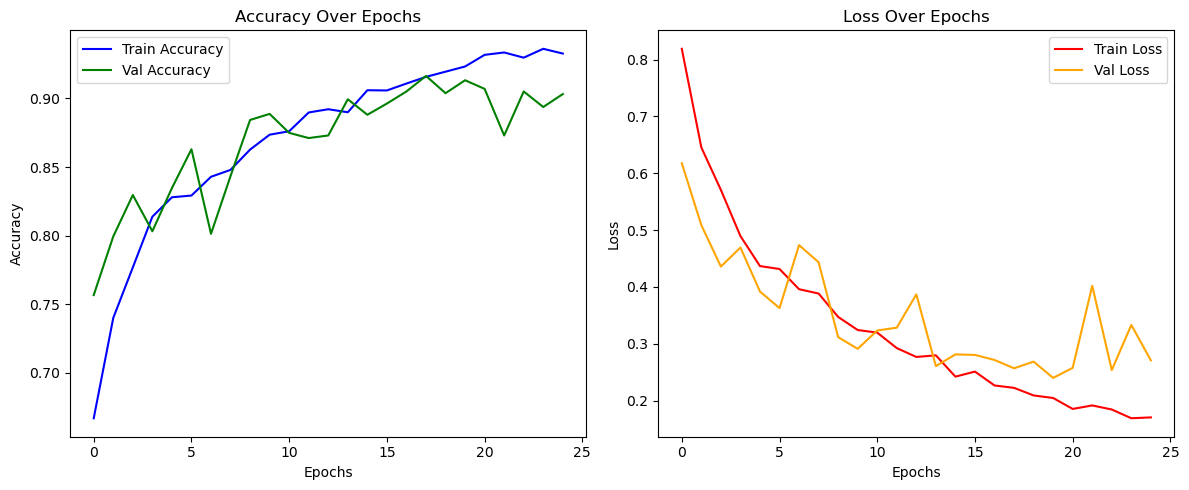

In [30]:
# 7. Plot training vs validation accuracy & loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

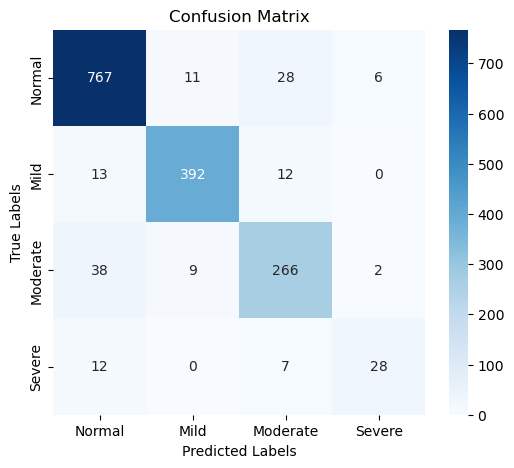

In [31]:
import seaborn as sns

# 1. Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Mild', 'Moderate', 'Severe'], yticklabels=['Normal', 'Mild', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


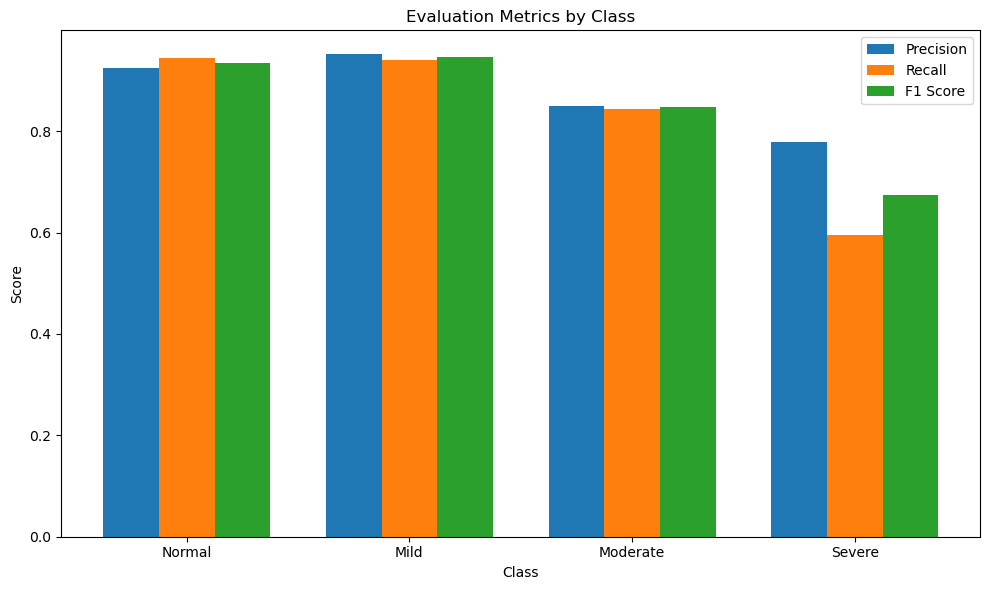

In [32]:
# Assuming cm has shape (4, 4) for confusion matrix (class-wise)
classes = ['Normal', 'Mild', 'Moderate', 'Severe']

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Custom color palette
colors_precision = ['#4CAF50', '#FF9800', '#2196F3', '#9C27B0']  # Green, Orange, Blue, Purple
colors_recall = ['#FFC107', '#673AB7', '#00BCD4', '#8BC34A']  # Amber, Deep Purple, Cyan, Light Green
colors_f1 = ['#FF5722', '#607D8B', '#CDDC39', '#E91E63']  # Deep Orange, Blue Grey, Lime, Pink

# Plotting
x = np.arange(len(classes))  # The class labels (Normal, Mild, etc.)
width = 0.25  # Bar
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for precision, recall, and F1 score
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1 Score')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()



In [33]:
# 8. Save the model
model.save("paralysis_detection_lstm_model.keras")

In [34]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed

# Reshape input for CNN+LSTM (sequence of 1 image)
X = X.reshape(X.shape[0], 1, img_size, img_size, 3)  # (samples, time_steps, height, width, channels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN + LSTM Model
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(1, img_size, img_size, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


C:\Users\Bhuvana\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - accuracy: 0.6668 - loss: 0.8430 - val_accuracy: 0.9183 - val_loss: 0.2096
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - accuracy: 0.9075 - loss: 0.2737 - val_accuracy: 0.9302 - val_loss: 0.1647
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - accuracy: 0.9338 - loss: 0.1922 - val_accuracy: 0.9497 - val_loss: 0.1599
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.9488 - loss: 0.1573 - val_accuracy: 0.9277 - val_loss: 0.1799
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.9466 - loss: 0.1499 - val_accuracy: 0.9648 - val_loss: 0.0997
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.9550 - loss: 0.1331 - val_accuracy: 0.9598 - val_loss: 0.1105
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.9645 - loss: 0.0953 - val_accuracy: 0.9705 - val_loss: 0.0962
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.9732 - loss: 0

In [36]:
# Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


In [37]:
acc = np.mean(y_pred_classes == y_true)
prec = precision_score(y_true, y_pred_classes, average='weighted')
rec = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
mae = mean_absolute_error(y_true, y_pred_classes)
rmse = mean_squared_error(y_true, y_pred_classes, squared=False)
cm = confusion_matrix(y_true, y_pred_classes)

C:\Users\Bhuvana\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[802   4   4   2]
 [  0 402  15   0]
 [  1  17 297   0]
 [  0   0   9  38]]


In [39]:
print("\nEvaluation Metrics:")
print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("F1 Score:", round(f1, 4))
print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))


Evaluation Metrics:
Accuracy: 0.9673
Precision: 0.9678
Recall: 0.9673
F1 Score: 0.9673
MAE: 0.0383
RMSE: 0.2284


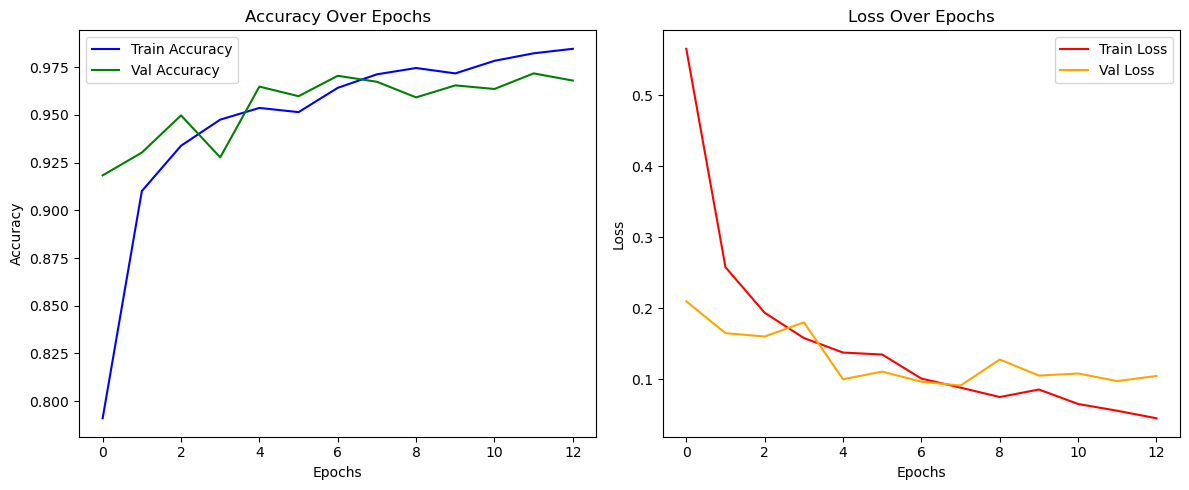

In [40]:
# Plot accuracy & loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

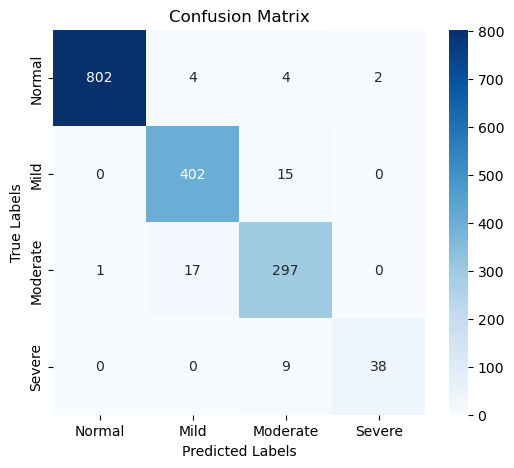

In [41]:
import seaborn as sns

# 1. Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Mild', 'Moderate', 'Severe'], yticklabels=['Normal', 'Mild', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


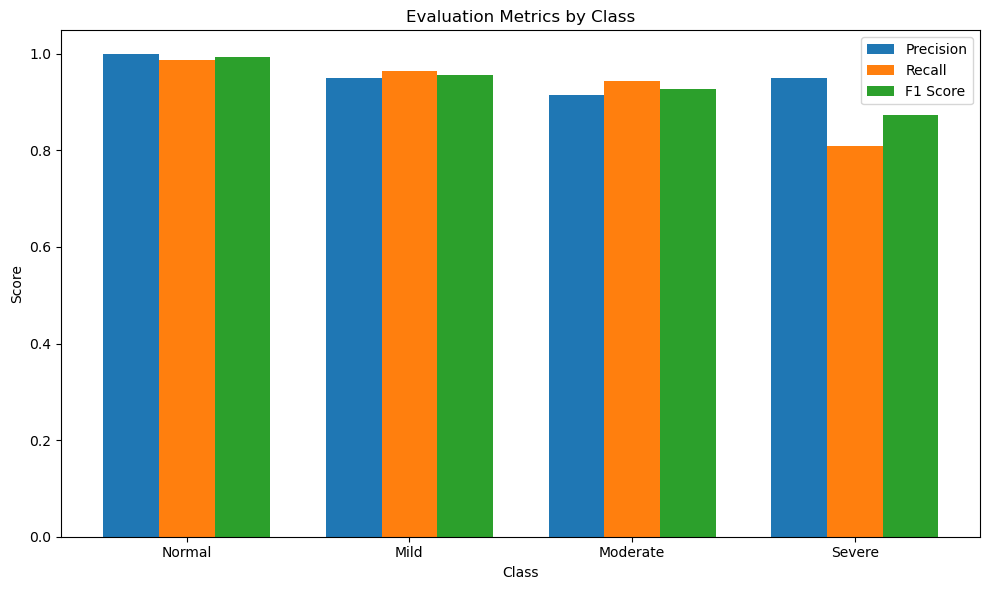

In [42]:
# Assuming cm has shape (4, 4) for confusion matrix (class-wise)
classes = ['Normal', 'Mild', 'Moderate', 'Severe']

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Custom color palette
colors_precision = ['#4CAF50', '#FF9800', '#2196F3', '#9C27B0']  # Green, Orange, Blue, Purple
colors_recall = ['#FFC107', '#673AB7', '#00BCD4', '#8BC34A']  # Amber, Deep Purple, Cyan, Light Green
colors_f1 = ['#FF5722', '#607D8B', '#CDDC39', '#E91E63']  # Deep Orange, Blue Grey, Lime, Pink

# Plotting
x = np.arange(len(classes))  # The class labels (Normal, Mild, etc.)
width = 0.25  # Bar
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for precision, recall, and F1 score
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1 Score')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()



In [43]:
# Save model
model.save("paralysis_detection_cnn_lstm_model.keras")

In [44]:
from IPython import get_ipython

notebook = get_ipython().user_ns['In']
full_code = ""
for cell in notebook:
    if cell.strip() != "":
        full_code += cell + "\n\n" + "#"*80 + "\n\n"

print(full_code)


import shutil

# Define the output path for organized labeled images
output_base = 'D:/labeled'

# Create the labeled folders if they don't exist
label_dirs = {
    'Normal': os.path.join(output_base, 'normal'),
    'Mild': os.path.join(output_base, 'mild'),
    'Moderate': os.path.join(output_base, 'moderate'),
    'Severe': os.path.join(output_base, 'severe')
}

for dir_path in label_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

# Copy files into respective folders
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    for file in os.listdir(folder_path):
        path = os.path.join(folder_path, file)
        try:
            # Find the label for this file from image_label_map
            for filename, label_name in image_label_map:
                if filename == file:
                    dst_path = os.path.join(label_dirs[label_name], file)
                    shutil.copy(path, dst_path)
                    break
        except Ex